In [23]:
import kagglehub
zlatan599_garbage_dataset_classification_path = kagglehub.dataset_download('zlatan599/garbage-dataset-classification')

print('Data source import complete.')


Data source import complete.


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [25]:
# Path to your dataset
data_dir = zlatan599_garbage_dataset_classification_path + "/Garbage_Dataset_Classification/images"

In [26]:
classes = os.listdir(data_dir)
print(f'Classes: {classes}')

Classes: ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


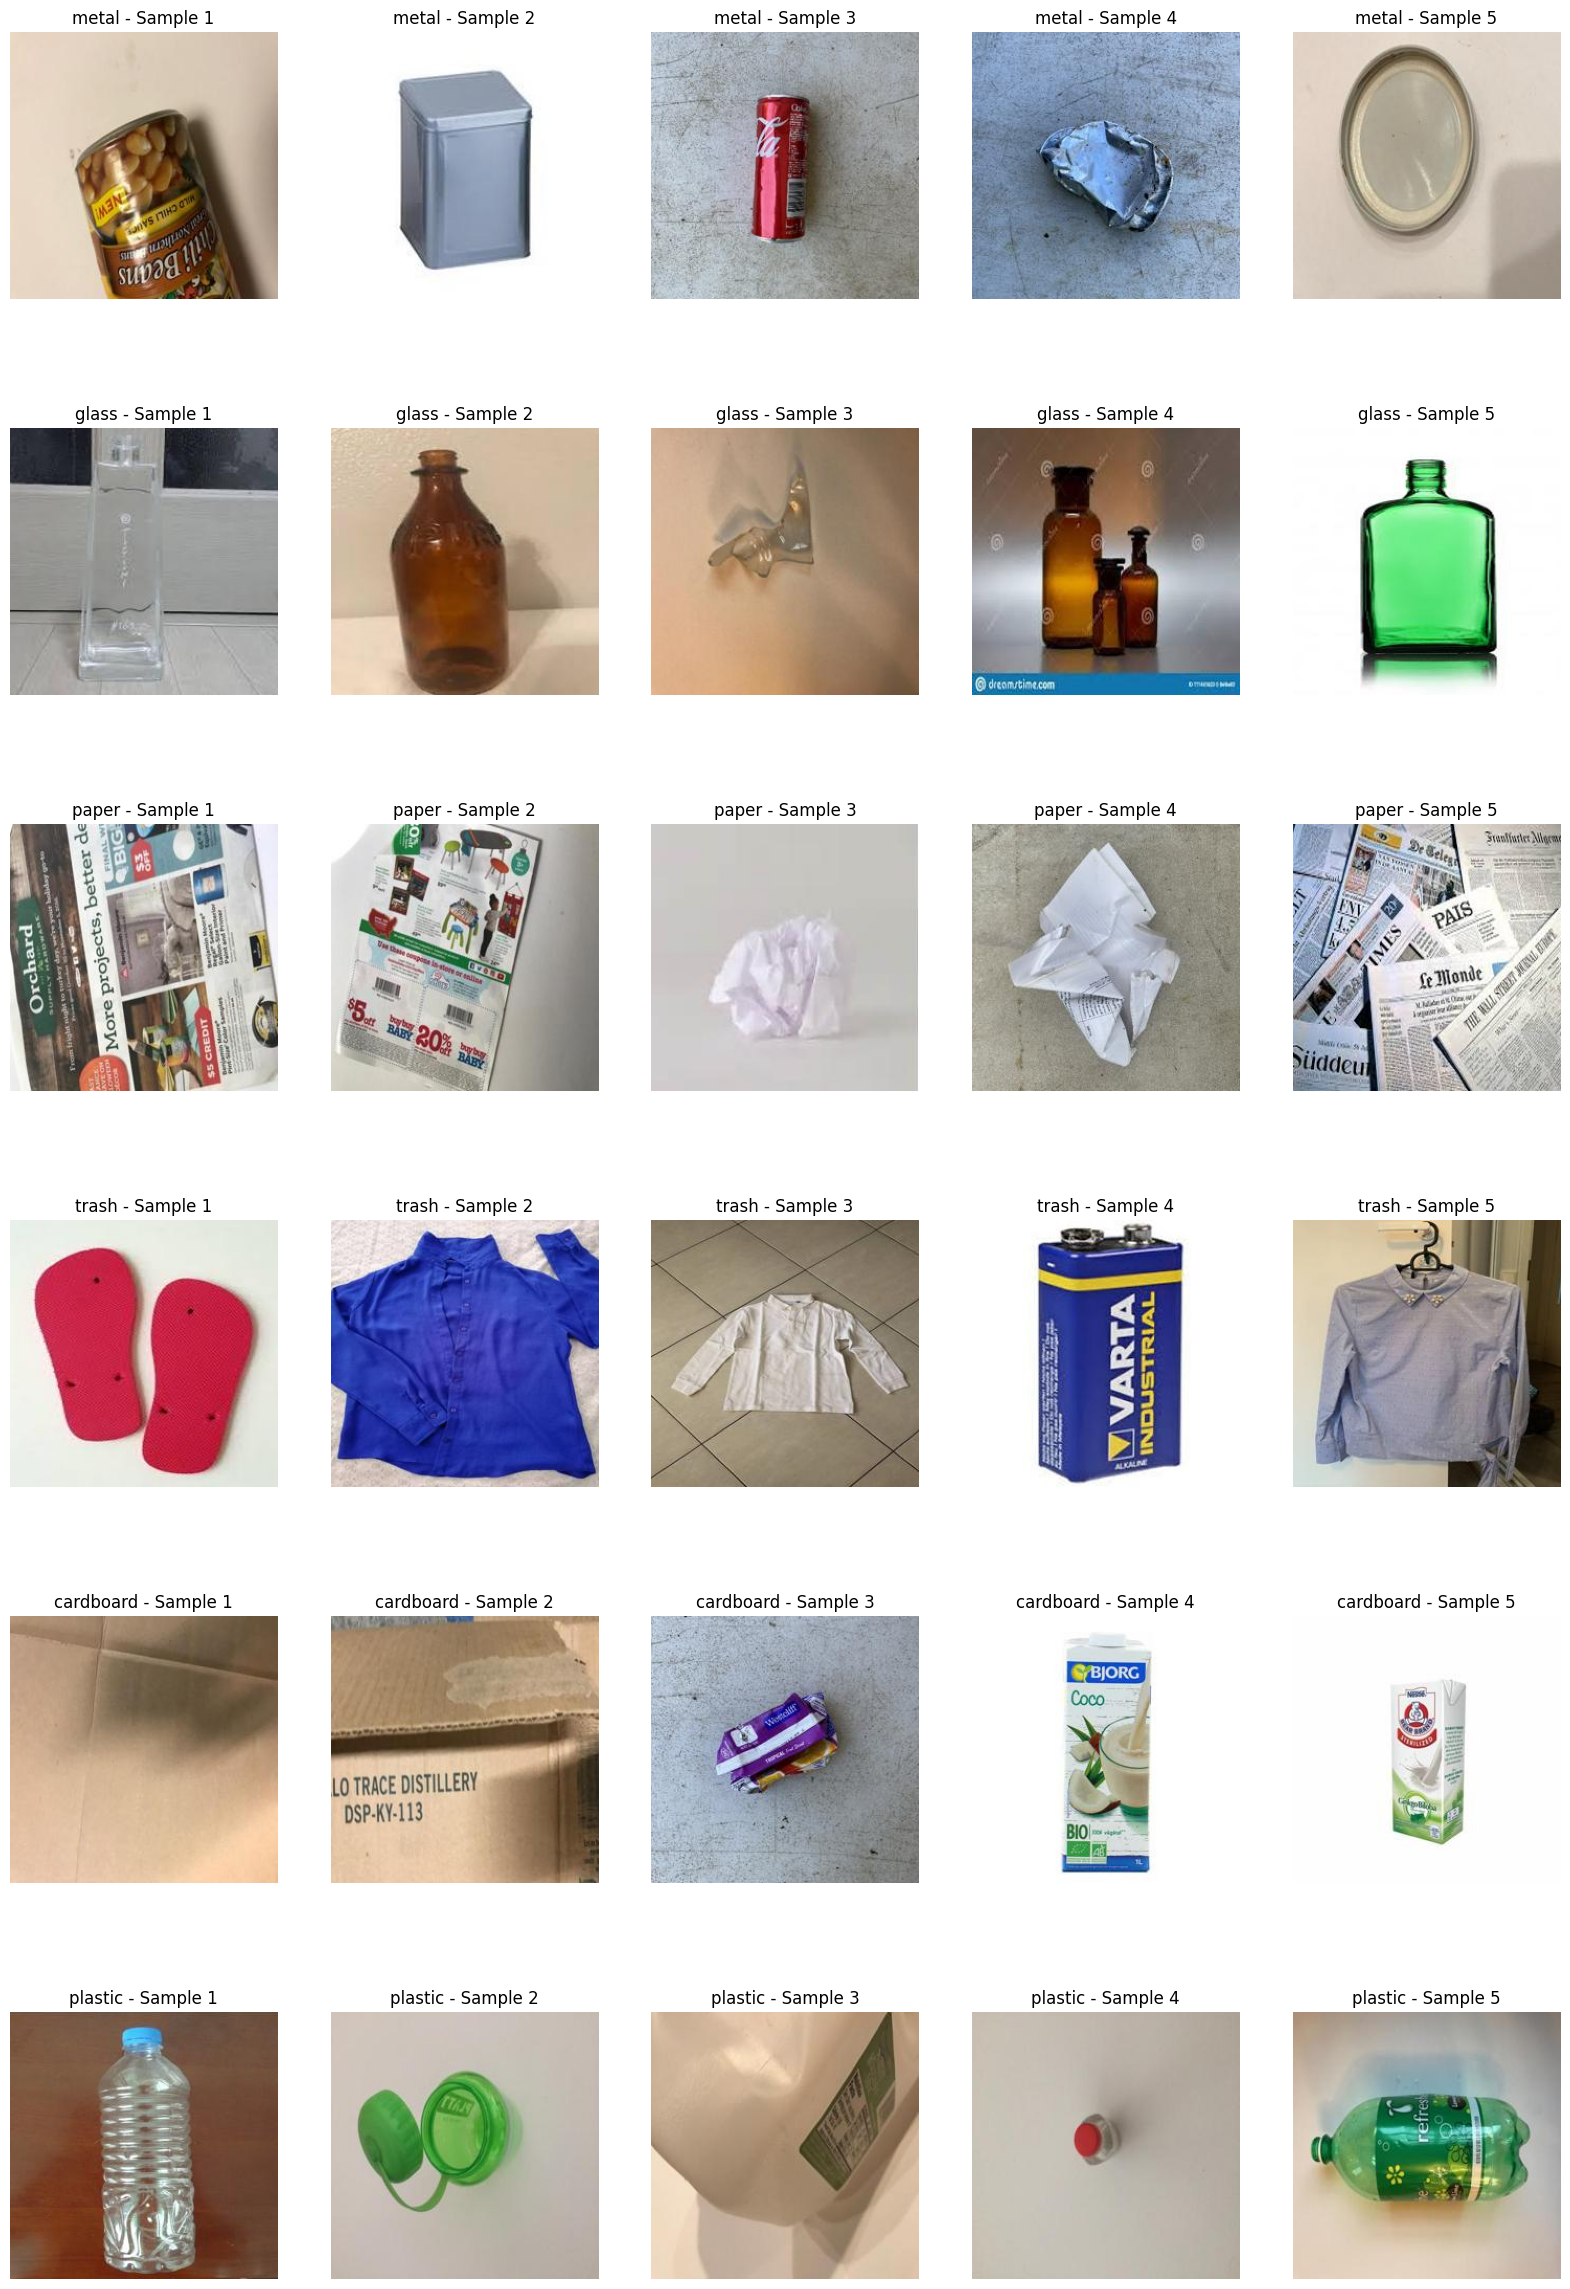

In [27]:
def visualize_images(data_dir, classes, num_samples=5):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(20, 5 * len(classes)))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        images = os.listdir(class_dir)
        for j in range(num_samples):
            img_path = os.path.join(class_dir, images[j])
            img = plt.imread(img_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'{class_name} - Sample {j+1}')
            axes[i, j].axis('off')
    plt.show()

visualize_images(data_dir, classes)

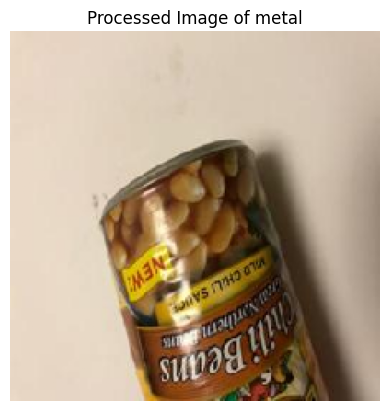

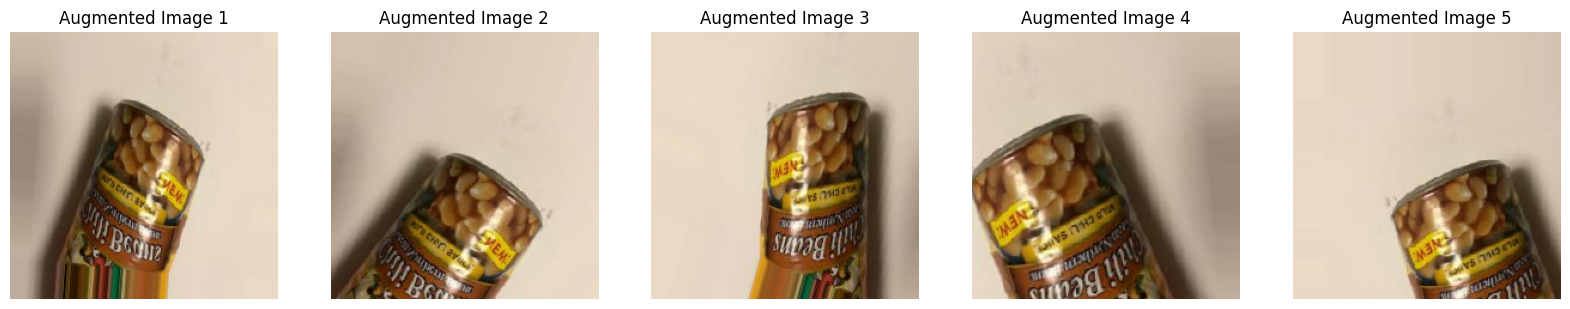

In [28]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize
    return img_array

# Example usage
img_path = os.path.join(data_dir, classes[0], os.listdir(os.path.join(data_dir, classes[0]))[0])
img_array = preprocess_image(img_path)
plt.imshow(img_array)
plt.title(f'Processed Image of {classes[0]}')
plt.axis('off')
plt.show()

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Example usage
img_array = np.expand_dims(img_array, axis=0)
augmented_images = datagen.flow(img_array, batch_size=1)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    aug_img = next(augmented_images)[0]
    axes[i].imshow(aug_img)
    axes[i].set_title(f'Augmented Image {i+1}')
    axes[i].axis('off')
plt.show()

In [29]:
img_size = (128, 128)

images=[]
labels=[]
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_dir):
        continue
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)

        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(class_name)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

images = np.array(images)
labels = np.array(labels)
img = []
for i in images:
    img_resized = cv2.resize(i, (224, 224))
    img.append(img_resized)

images = np.array(img)


print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("Unique labels:", np.unique(labels))

Images shape: (13901, 224, 224, 3)
Labels shape: (13901,)
Unique labels: ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']


In [30]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [31]:
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train set size: {len(x_train)}')
print(f'Validation set size: {len(x_val)}')
print(f'Test set size: {len(x_test)}')

Train set size: 9730
Validation set size: 2085
Test set size: 2086


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Input,
    GlobalAveragePooling2D
)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization


# Define image dimensions and number of classes
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 6

# Transfer Learning with EfficientNet + Fine-tuning
def build_transfer_learning_model():
    base_model = EfficientNetB0(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False   # freeze all layers initially

    # -----------------------------
    # Fine-tuning: unfreeze last 20 layers
    # -----------------------------
    fine_tune_at = len(base_model.layers) - 20
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),  # Add Batch Normalization after pooling
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Add L2 regularization
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax', name='output_layer', kernel_regularizer=l2(0.001))  # L2 on output as well
        ], name="EfficientNetB0_Transfer_Learning")
    return model

# --- Create and compile the model ---
model1 = build_transfer_learning_model()


# Print summary
model1.summary()


Model: "EfficientNetB0_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,137,065 (15.78 MB)

 Trainable params: 1,435,894 (5.48 MB)

 Non-trainable params: 2,701,171 (10.30 MB)

In [33]:
# Compile the model
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
# Train
hist1 = model1.fit(
    x_train,y_train,
    epochs=10,batch_size=8,
    validation_data=(x_val,y_val)
)
# Save model
model1.save("trained_EN_model.h5")

Epoch 1/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 77s 36ms/step - accuracy: 0.4712 - loss: 1.7025 - val_accuracy: 0.8446 - val_loss: 0.5873
Epoch 2/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.7563 - loss: 0.8328 - val_accuracy: 0.8748 - val_loss: 0.4775
Epoch 3/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8104 - loss: 0.6765 - val_accuracy: 0.8945 - val_loss: 0.4298
Epoch 4/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.8386 - loss: 0.5867 - val_accuracy: 0.9079 - val_loss: 0.3995
Epoch 5/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8579 - loss: 0.5385 - val_accuracy: 0.9127 - val_loss: 0.3908
Epoch 6/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8701 - loss: 0.4975 - val_accuracy: 0.9132 - val_loss: 0.3763
Epoch 7/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.8951 - loss: 0.4223 - val_accuracy: 0.9151 - val_loss: 0.3563
Epoch 8/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9000 -

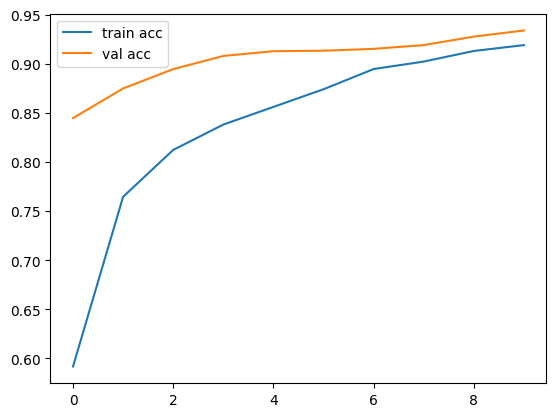

In [35]:
import matplotlib.pyplot as plt

plt.plot(hist1.history['accuracy'], label='train acc')
plt.plot(hist1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [36]:
loss, accuracy = model1.evaluate(x_test, y_test, batch_size=8)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9354 - loss: 0.3598
Test Loss: 0.3629699945449829
Test Accuracy: 0.9328858852386475


In [37]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np

# Get predictions on test data
y_pred_probs = model1.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# F1-Score (macro or weighted)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

#classification report
print("\n\n",classification_report(y_test, y_pred))


66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step
F1 Score: 0.9330
Confusion Matrix:
 [[307   0   2  15   2   3]
 [  1 332   3   2  14   5]
 [  1   4 302   3   6   0]
 [  8   0  10 299   1   3]
 [  4   9  10   1 326   6]
 [  2   0   6   8  11 380]]


               precision    recall  f1-score   support

           0       0.95      0.93      0.94       329
           1       0.96      0.93      0.95       357
           2       0.91      0.96      0.93       316
           3       0.91      0.93      0.92       321
           4       0.91      0.92      0.91       356
           5       0.96      0.93      0.95       407

    accuracy                           0.93      2086
   macro avg       0.93      0.93      0.93      2086
weighted avg       0.93      0.93      0.93      2086



In [48]:
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Transfer Learning with MobileNetV2 + Fine-tuning
def build_transfer_learning_model2():
    base_model = MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False   # freeze all layers initially

    # -----------------------------
    # Fine-tuning: unfreeze last 20 layers
    # -----------------------------
    fine_tune_at = len(base_model.layers) - 20
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),  # Add Batch Normalization after pooling
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Add L2 regularization
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax', name='output_layer', kernel_regularizer=l2(0.001))  # L2 on output as well
        ], name="MobileNEtV2_Transfer_Learning")
    return model

# --- Create the final model ---
# This combines the frozen base model and our new classification head.
model2 = build_transfer_learning_model2()

In [42]:
# --- Compile the model ---
model2.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])


# --- Display the model architecture ---
# This is a great way to verify your model's structure and see the number of trainable parameters.
model2.summary()

Model: "MobileNEtV2_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,345,478 (8.95 MB)

 Trainable params: 1,291,014 (4.92 MB)

 Non-trainable params: 1,054,464 (4.02 MB)

In [43]:
# Train
hist2 = model2.fit(
    x_train,y_train,
    epochs=25,batch_size=8,
    validation_data=(x_val,y_val)
)
# --- Save your trained model ---
model2.save('waste_classifier_mobilenet.h5')

print("\n Training complete and model has been saved!")

Epoch 1/25
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - accuracy: 0.3429 - loss: 2.2133 - val_accuracy: 0.4556 - val_loss: 2.3761
Epoch 2/25
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.5271 - loss: 1.4548 - val_accuracy: 0.4624 - val_loss: 2.2570
Epoch 3/25
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.5791 - loss: 1.2801 - val_accuracy: 0.4916 - val_loss: 2.7660
Epoch 4/25
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6189 - loss: 1.1789 - val_accuracy: 0.6369 - val_loss: 1.4738
Epoch 5/25
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6668 - loss: 1.0356 - val_accuracy: 0.6120 - val_loss: 1.3921
Epoch 6/25
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6831 - loss: 1.0000 - val_accuracy: 0.6273 - val_loss: 1.4720
Epoch 7/25
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7033 - loss: 0.9070 - val_accuracy: 0.6058 - val_loss: 1.6707
Epoch 8/25
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7410 -

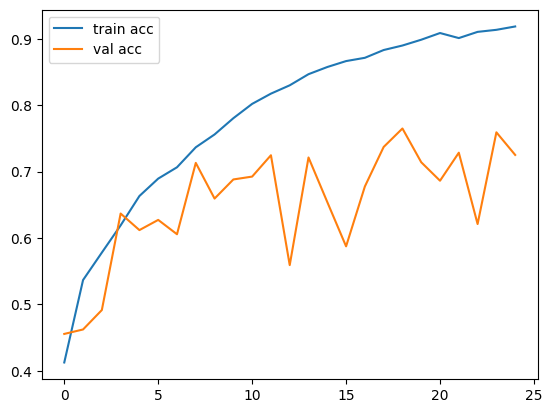

In [44]:
import matplotlib.pyplot as plt

plt.plot(hist2.history['accuracy'], label='train acc')
plt.plot(hist2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [45]:
loss, accuracy = model2.evaluate(x_test, y_test, batch_size=8)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7340 - loss: 1.4114
Test Loss: 1.4276736974716187
Test Accuracy: 0.730105459690094


In [46]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np

# Get predictions on test data
y_pred_probs = model2.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# F1-Score (macro or weighted)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

#classification report
print("\n\n",classification_report(y_test, y_pred))


66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step
F1 Score: 0.7310
Confusion Matrix:
 [[312   8   3   2   3   1]
 [ 27 298  19   2   6   5]
 [ 24  26 256   2   3   5]
 [ 72  19  19 205   3   3]
 [ 38  78  17   4 211   8]
 [ 67  60  22   7  10 241]]


               precision    recall  f1-score   support

           0       0.58      0.95      0.72       329
           1       0.61      0.83      0.70       357
           2       0.76      0.81      0.79       316
           3       0.92      0.64      0.76       321
           4       0.89      0.59      0.71       356
           5       0.92      0.59      0.72       407

    accuracy                           0.73      2086
   macro avg       0.78      0.74      0.73      2086
weighted avg       0.78      0.73      0.73      2086



In [57]:
 #Transfer Learning with MobileNetV2 + Fine-tuning
def build_transfer_learning_model3():
    base_model = ResNet50(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False   # freeze all layers initially

    # -----------------------------
    # Fine-tuning: unfreeze last 20 layers
    # -----------------------------
    fine_tune_at = len(base_model.layers) - 20
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),  # Add Batch Normalization after pooling
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Add L2 regularization
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax', name='output_layer', kernel_regularizer=l2(0.001))  # L2 on output as well
        ], name="ResNet50_Transfer_Learning")
    return model

# --- Create the final model ---
# This combines the frozen base model and our new classification head.
model3 = build_transfer_learning_model3()

In [58]:
# --- Compile the model ---
model3.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])


# --- Display the model architecture ---
# This is a great way to verify your model's structure and see the number of trainable parameters.
model3.summary()

Model: "ResNet50_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,727,430 (90.51 MB)

 Trainable params: 9,066,950 (34.59 MB)

 Non-trainable params: 14,660,480 (55.93 MB)

In [59]:
# Train
hist3 = model3.fit(
    x_train,y_train,
    epochs=15,batch_size=8,
    validation_data=(x_val,y_val)
)
# --- Save your trained model ---
model3.save('waste_classifier_resnet50.h5')

print("\n Training complete and model has been saved!")

Epoch 1/15
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 72s 42ms/step - accuracy: 0.5533 - loss: 1.8924 - val_accuracy: 0.7962 - val_loss: 1.0917
Epoch 2/15
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.7230 - loss: 0.9601 - val_accuracy: 0.8139 - val_loss: 0.7861
Epoch 3/15
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.7926 - loss: 0.7621 - val_accuracy: 0.8767 - val_loss: 0.5624
Epoch 4/15
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.8195 - loss: 0.7140 - val_accuracy: 0.8873 - val_loss: 0.5098
Epoch 5/15
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.8493 - loss: 0.6228 - val_accuracy: 0.9118 - val_loss: 0.4613
Epoch 6/15
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.8725 - loss: 0.5640 - val_accuracy: 0.9002 - val_loss: 0.4878
Epoch 7/15
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.8965 - loss: 0.4727 - val_accuracy: 0.9127 - val_loss: 0.4745
Epoch 8/15
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9127 -

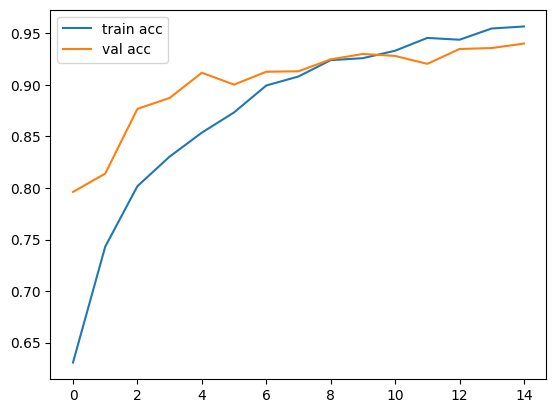

In [60]:
import matplotlib.pyplot as plt

plt.plot(hist3.history['accuracy'], label='train acc')
plt.plot(hist3.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [64]:
loss, accuracy = model3.evaluate(x_test, y_test, batch_size=8)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9334 - loss: 0.3896
Test Loss: 0.4549316167831421
Test Accuracy: 0.9271332621574402


In [63]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np

# Get predictions on test data
y_pred_probs = model3.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# F1-Score (macro or weighted)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

#classification report
print("\n\n",classification_report(y_test, y_pred))


66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step
F1 Score: 0.9273
Confusion Matrix:
 [[304   0   0  10   9   6]
 [  0 337   5   0   7   8]
 [  0   4 284   6  11  11]
 [  6   1   7 294   3  10]
 [  1   8   6   4 328   9]
 [  2   1   4   5   8 387]]


               precision    recall  f1-score   support

           0       0.97      0.92      0.95       329
           1       0.96      0.94      0.95       357
           2       0.93      0.90      0.91       316
           3       0.92      0.92      0.92       321
           4       0.90      0.92      0.91       356
           5       0.90      0.95      0.92       407

    accuracy                           0.93      2086
   macro avg       0.93      0.93      0.93      2086
weighted avg       0.93      0.93      0.93      2086

